<a href="https://colab.research.google.com/github/Gabriel-PC/Desafio-DATA_Viking---Detector-de-Fumaca/blob/main/Desafio_DATA_Viking_Detector_de_Fumaca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import pandas as pd
import numpy as np
import warnings
from pandas._libs.hashtable import value_count
from random import sample 
import random
# mudando o formato do tempo, pelo menos para o mostrador
from datetime import timezone
import datetime
from datetime import datetime
from pytz import timezone

# Matplotlib
from pandas.plotting import autocorrelation_plot
import matplotlib
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
# Plotly Express
import plotly.express as px

# configs
pd.set_option('display.max_columns', 30)
warnings.filterwarnings('ignore')
# Ajustando a apresentação dos dados de float muito grandes
pd.options.display.float_format="{:20,.2f}".format

# modelo
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf 
import statsmodels.api as sm

# warnings
import warnings
warnings.filterwarnings("ignore")

In [37]:
# leitura da base de dados
df = pd.read_csv('https://raw.githubusercontent.com/Gabriel-PC/Desafio-DATA_Viking---Detector-de-Fumaca/main/Dados_Detec%C3%A7%C3%A3o_Fumasa.csv',encoding = 'ISO-8859-1').reset_index(drop=True) #O encoding = 'ISO-8859-1 ficou de gaiato
#.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


In [38]:
# Eliminando coluna de índice falso, alinhando com a linha de tempo
df = df.sort_values("UTC", ascending=True).reset_index(drop=True)
df = df.drop(columns="Unnamed: 0")

In [39]:
# Verificando campos nulos
print(df.isna().sum())
# Verificando a consistência dos dados (max, min, count): temperatura, umidade relativa, pressão, alarme: ok
print(df.describe(include = 'all'))
# Verificando dados únicos: alarme, tempo e 'index': ok
print(df.nunique())
# Removendo as linhas com valores duplicados
df = df.drop_duplicates()
print(df) #esperado já que os tempos são todos únicos

UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64
                       UTC       Temperature[C]          Humidity[%]  \
count            62,630.00            62,630.00            62,630.00   
mean      1,654,792,066.18                15.97                48.54   
std             110,002.49                14.36                 8.87   
min       1,654,712,187.00               -22.01                10.74   
25%       1,654,743,244.25                10.99                47.53   
50%       1,654,761,919.50                20.13                50.15   
75%       1,654,777,576.75                25.41                53.24   
max       1,655,130,051.00                59.93                75.20   

                 TVOC[ppb]            

In [40]:
# === FALHOU ===
# Getting the current date
# and time
#dt2 = datetime.datetime.now(timezone.utc)
  
#utc_time = dt2.replace(tzinfo=timezone.utc)
#utc_timestamp = utc_time.timestamp()
  
#print(utc_timestamp)
#timestamp = utc_timestamp
#dt = datetime.fromtimestamp(timestamp, tz = timezone("America/Sao_Paulo"))
#dt3 = dt2.astimezone(timezone("America/Sao_Paulo"))
#print(dt3)
#df["UTC"] = pd.to_datetime(df["UTC"], format='%S') - calendar.timegm()
#df['UTC'] = pd.DatetimeIndex(df["UTC"]).sec
#df.dtypes

In [41]:
#pd.Index(df["Unnamed: 0"])

In [42]:
from joblib.parallel import time
from numpy.ma.core import append
# converter string para número
#timestamp = float("1444253422")
time_change = []
fire_set = 0
for x in df.index :
    timestamp = df.at[x, "UTC"] 
# converter o timestamp para uma data e hora em um timezone específico
    dt = datetime.fromtimestamp(timestamp, tz = timezone("Asia/Tokyo"))
#print(dt) # 2015-10-08 06:30:22.348341+09:00
# se quiser mostrar em outro formato
#print(dt.strftime("%d/%m/%Y %H:%M:%S.%f %z")) # 08/10/2015 06:30:22.348341 +0900
# converter para outro timezone
#dt = dt.astimezone(timezone("Europe/London"))
    dt = dt.astimezone(timezone("America/Sao_Paulo"))
    if fire_set != df.at[x, "Fire Alarm"] :
        print(dt.time(), dt.date(), "  set mudou para  ", df.at[x, "Fire Alarm"], "  só conferindo  ", df.at[x, "UTC"]) # 2015-10-07 22:30:22.348341+01:00
        time_change.append(x)
        #print(df.at[x, "Fire Alarm"])
        #print(dt.at[x, ""])
    fire_set = df.at[x, "Fire Alarm"]
print(time_change)
print(dt.strftime("%d/%m/%Y %H:%M:%S %z"))
#print(dt.strftime("%d/%m/%Y %H:%M:%S.%f %z")) # 07/10/2015 22:30:22.348341 +0100


15:16:30 2022-06-08   set mudou para   1   só conferindo   1654712190
15:16:32 2022-06-08   set mudou para   0   só conferindo   1654712192
22:01:49 2022-06-08   set mudou para   1   só conferindo   1654736509
04:55:43 2022-06-09   set mudou para   0   só conferindo   1654761343
05:48:41 2022-06-09   set mudou para   1   só conferindo   1654764521
20:16:45 2022-06-10   set mudou para   0   só conferindo   1654903005
20:17:18 2022-06-10   set mudou para   1   só conferindo   1654903038
09:45:08 2022-06-13   set mudou para   0   só conferindo   1655124308
09:45:11 2022-06-13   set mudou para   1   só conferindo   1655124311
09:45:13 2022-06-13   set mudou para   0   só conferindo   1655124313
[3, 5, 8922, 30738, 33916, 55732, 55765, 56886, 56889, 56891]
13/06/2022 11:20:51 -0300


### Sengudo pesquisa, existem pelo menos 4 tipos de detectores de fumaça:
- Fumaça (ótico (fotoelétrico) ou iônico)
- Chama (quando antes da fumaça, fábricas ou laboratórios)
- Temperatura (**velocímetro/minuto** 😲 ou valor fixo)

- Gás (presença de gás combustível - GLP, GNV, CO2, H+)

### TEMPERATURA
Em 1975, a International Organization for Standardization publicou a norma ISO 834 “FireResistance Tests – Elements of Building Construction”, fornecendo uma equação para estimar a temperatura em função do tempo para incêndio de materiais celulósicos.

## **θg - θgzero = 345 * log(8 * t + 1)**

onde:
- θg = temperatura dos gases quentes (atmosfera) do compartimento em chamas [°C]
- θgzero  = temperatura da atmosfera do compartimento no instante t = 0 [°C]
- t = tempo [min]

- tempo (min) = 0, θ (°C) = 5
- tempo (min) = 20, θ (°C) = 538 

In [43]:
# Verificar(Criar) coluna VELOCIMETRO para Temperatura (até o Fire Alarm passar de 0 para 1)

# Impraticável, uma vez que a mudança de tempo do "Fire Alarm" guardada (somente ímpares) em "time_change" ficou menor que 1 minuto, segundo a variável "fire_set".

### Curva “H” (EN 1991-2-2:2002) 

## **θg = 1080 * (1- 0.33 * e^ (-0.17*t) - 0.68 * e^ (-2.50*t) + 20**

A curva “H’ foi desenvolvida, a priori, para projetos de segurança contra-incêndio de indústrias petroquímicas e offshore; atualmente ela tem sido recomendada para projeto de túneis e outras vias de transporte de veículos movidos a combustíveis inflamáveis. Diferente da curva-padrão, a curva “H” é bem realista para representar incêndios de materiais derivados do petróleo que poderiam causar “pequenos” incêndios (CANER et al., 2005). 

In [44]:
# Verificar Raw H2

# Apesar de existir a fórmula com o tempo, não sei como utilizar, e não possuo uma tabela de comparação.

1    44757
0    17873
Name: Fire Alarm, dtype: int64
UTC                             -0.39
Temperature[C]                  -0.16
Humidity[%]                      0.40
TVOC[ppb]                       -0.21
eCO2[ppm]                       -0.10
Raw H2                           0.11
Raw Ethanol                     -0.34
Pressure[hPa]                    0.25
PM1.0                           -0.11
PM2.5                           -0.08
NC0.5                           -0.13
NC1.0                           -0.08
NC2.5                           -0.06
CNT                              0.67
Fire Alarm                       1.00
Name: Fire Alarm, dtype: float64


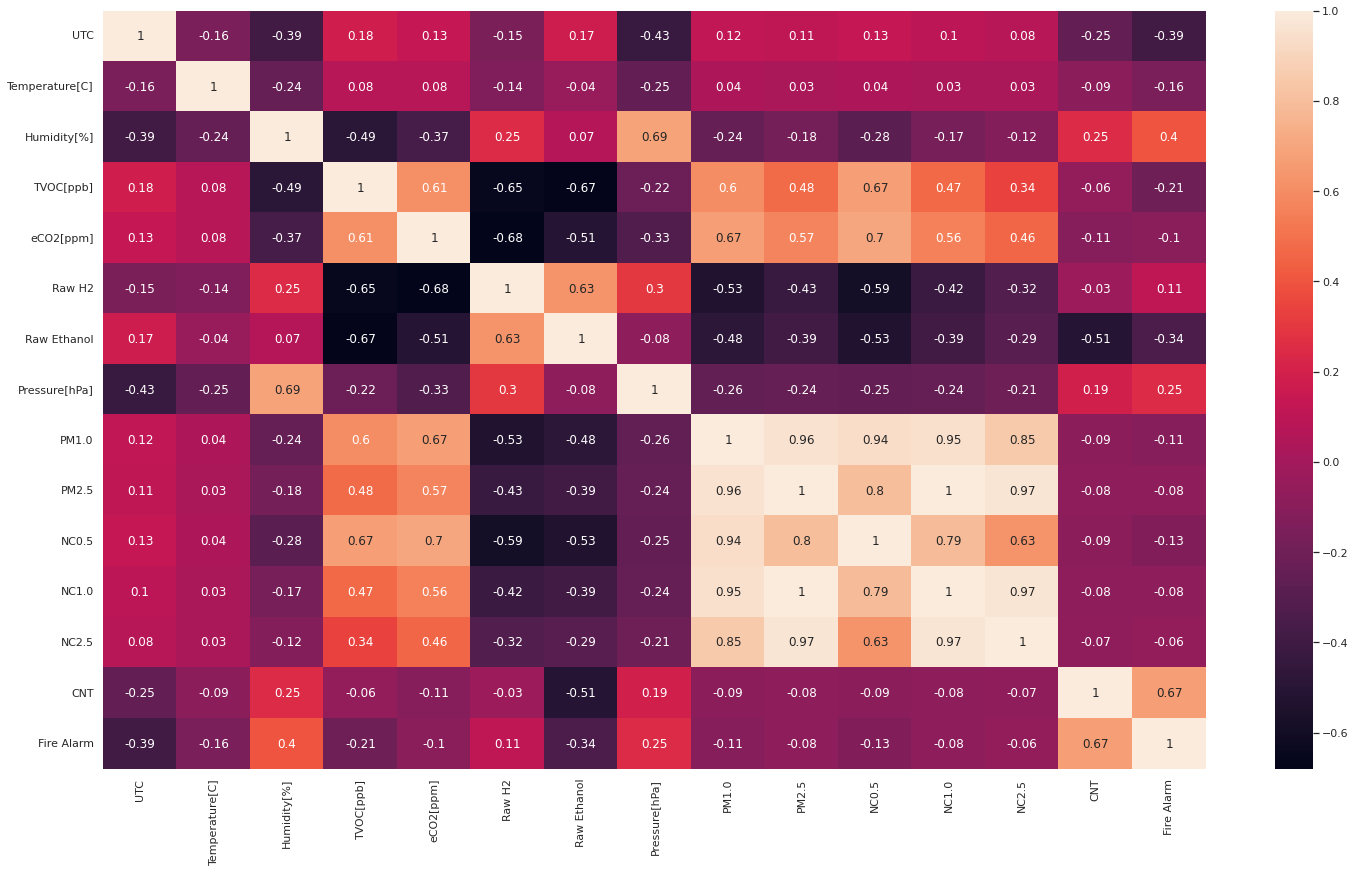

In [45]:
# Análise Gráfica e Insights
# Verificando os pontos onde o Alarme deu 1

print(df["Fire Alarm"].value_counts()) #melhor
#df.groupby('Fire Alarm').count()
Correlacao = round(df.corr(),2)
print(Correlacao["Fire Alarm"])
sns.set(rc = {'figure.figsize':(22,13)})
sns.heatmap(Correlacao, annot=True);


In [46]:
#sns.pairplot(Correlacao["Fire Alarm"], hue='sex')  #deu muito ruim, não parou de processar, mesmo com sample(100)
px.imshow(Correlacao, text_auto=True, aspect="auto", color_continuous_scale='RdBu')

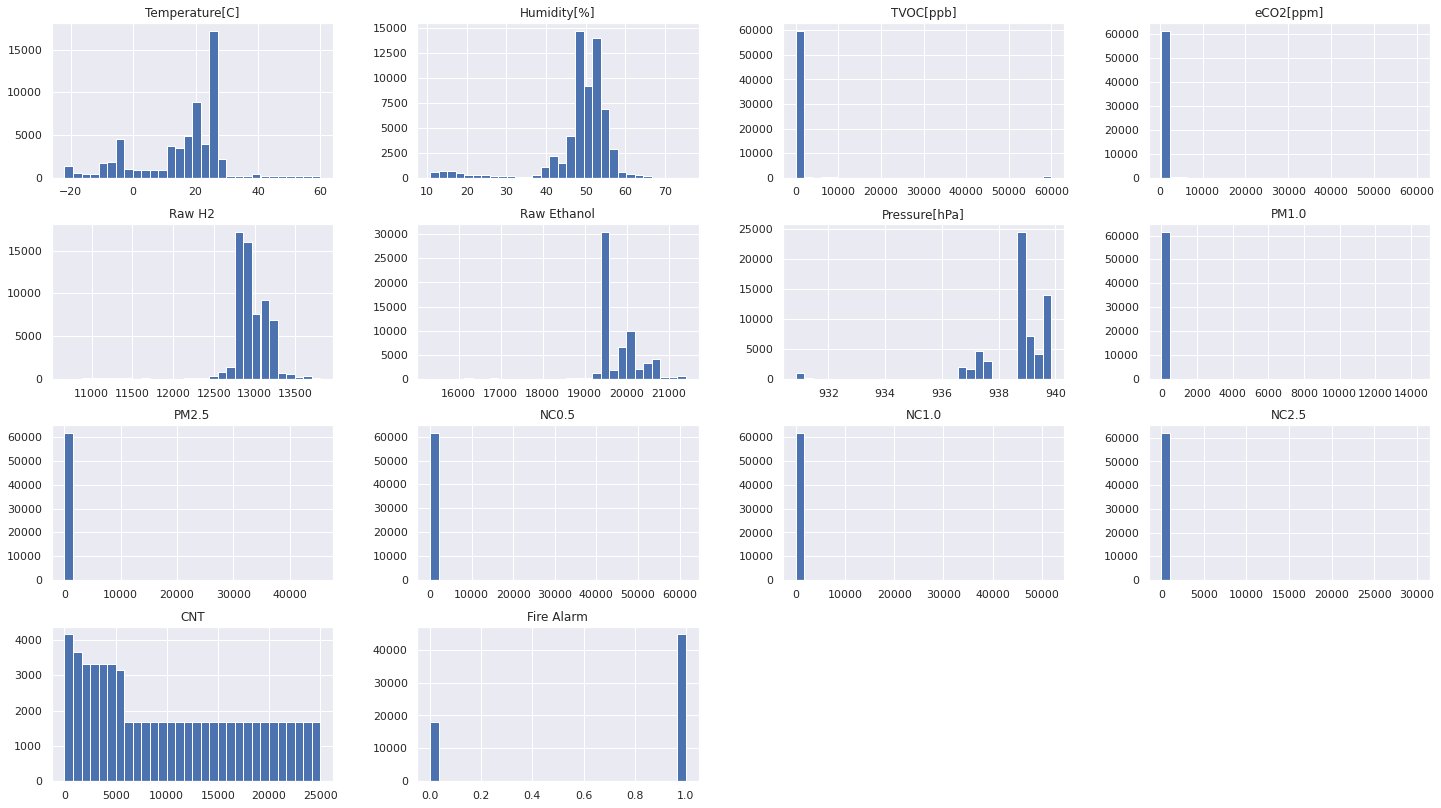

In [47]:
df.iloc[:,1:].hist(figsize = (22, 13), bins = 30);

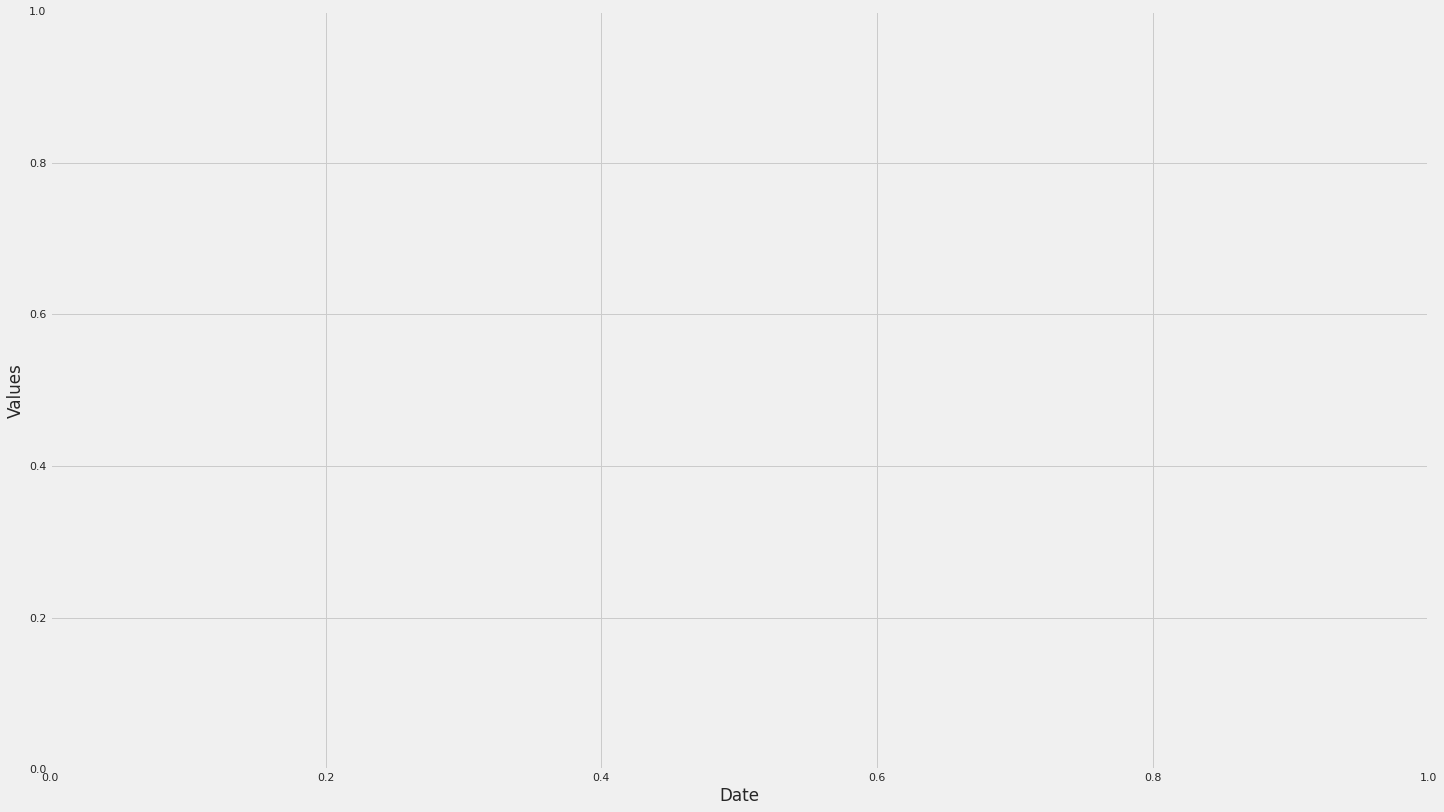

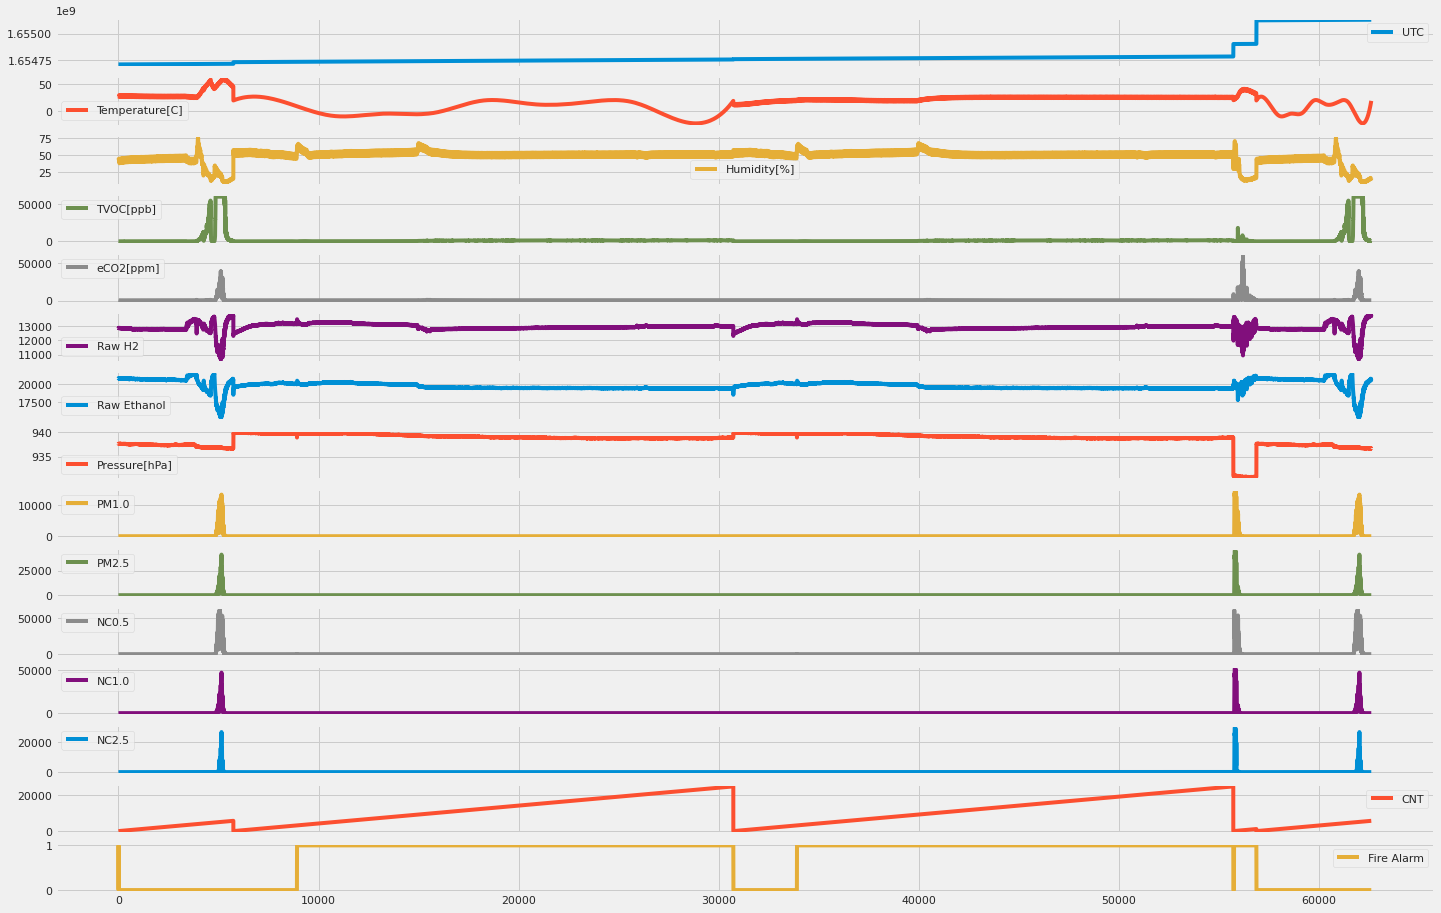

In [48]:
plt.style.use("fivethirtyeight")
plt.xlabel("Date")
plt.ylabel("Values")
df.plot(subplots=True, figsize=(22, 15));

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Text major ticklabel objects>)

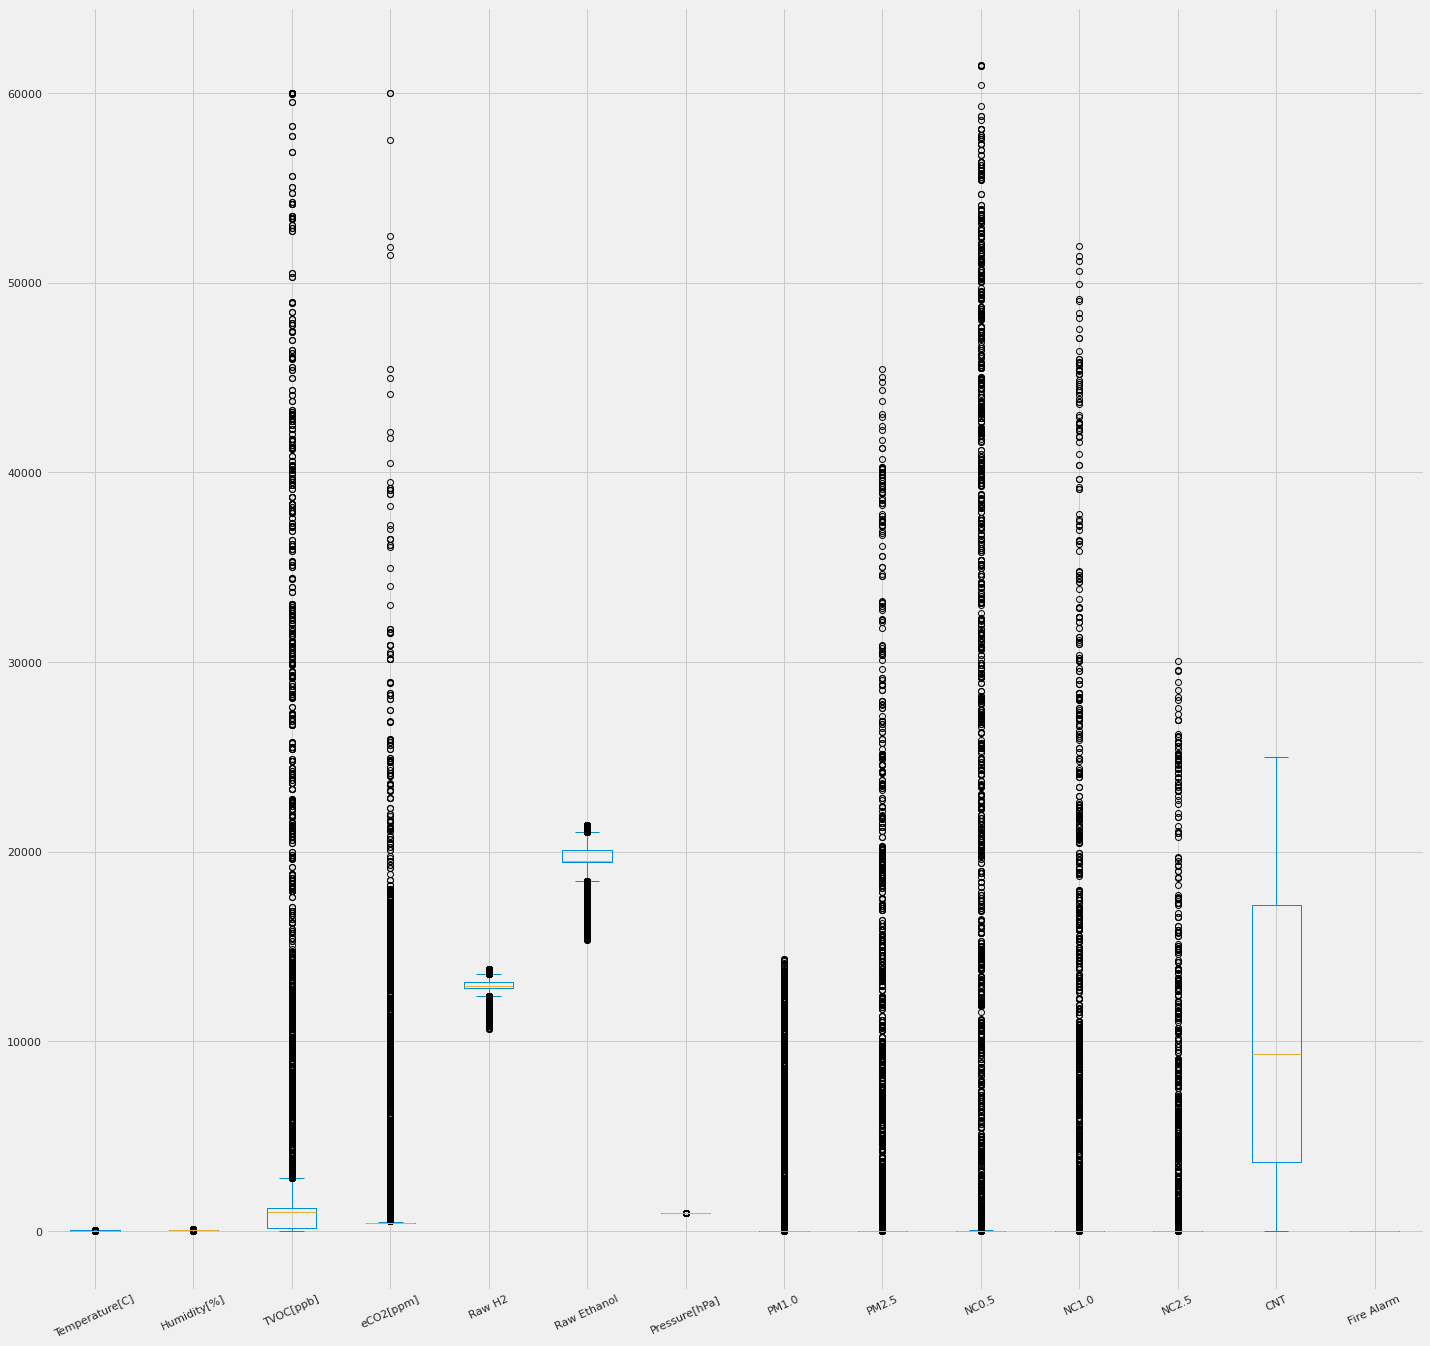

In [49]:
#for column in df.select_dtypes(include = object).columns[1:]:
#for column in df.columns[:]:
#    sns.boxplot(data=df[column]) #faiô
#    plt.xlabel('Tempo') 
#    plt.ylabel(column)
    
df.iloc[:,1:].plot(kind = 'box', figsize = (22, 22));
plt.xticks(rotation=25)
#sns.boxplot(data=df['CNT']);

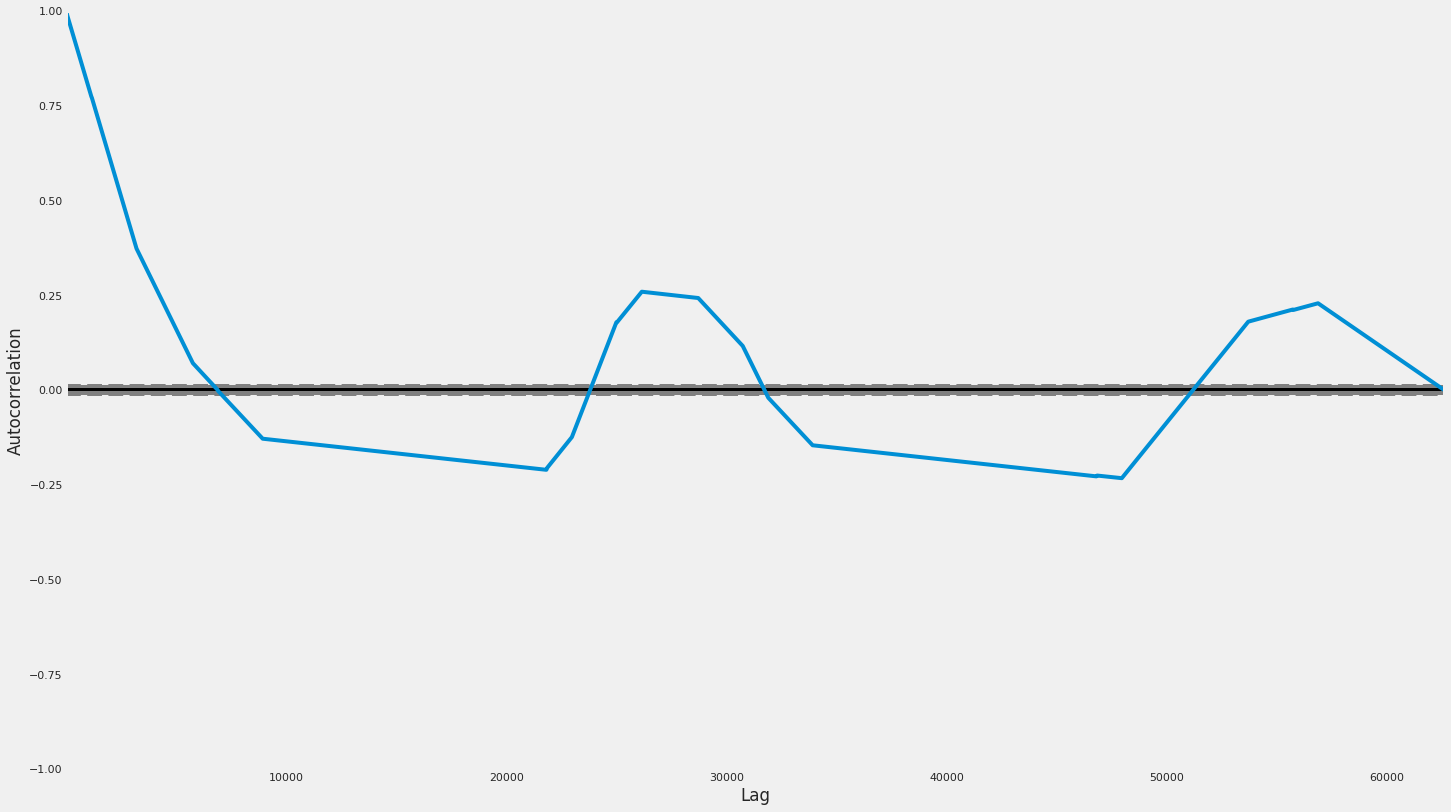

In [50]:
autocorrelation_plot(df["Fire Alarm"]);

#### Interpretando
**0.9** para mais ou para menos indica uma correlação muito forte

**0.7 a 0.9** positivo ou negativo indica uma correlação forte

*0.5 a 0.7 positivo ou negativo indica uma correlação moderada*

0.3 a 0.5 positivo ou negativo indica uma correlação fraca

0 a 0.3 positivo ou negativo indica uma correlação desprezível
- correlação não implica causalidade!

In [51]:
df.columns

Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]',
       'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5',
       'NC1.0', 'NC2.5', 'CNT', 'Fire Alarm'],
      dtype='object')

In [52]:
df.rename(
    columns = {
        'UTC':'UTC', 
        'Temperature[C]':'Temperatura', 
        'Humidity[%]':'Humidade', 
        'TVOC[ppb]': 'TVOC', 
        'eCO2[ppm]': 'eCO2',
        'Raw H2': 'Raw_H2', 
        'Raw Ethanol':'Raw_Eth', 
        'Pressure[hPa]':'Pressao', 
        'PM1.0':'PM1', 
        'PM2.5':'PM2', 
        'NC0.5':'NC05', 
        'NC1.0': 'NC10', 
        'NC2.5':'NC25', 
        'CNT':'CNT', 
        'Fire Alarm':'Fire_Alarm'
    },
    inplace = True
)
df.columns

Index(['UTC', 'Temperatura', 'Humidade', 'TVOC', 'eCO2', 'Raw_H2', 'Raw_Eth',
       'Pressao', 'PM1', 'PM2', 'NC05', 'NC10', 'NC25', 'CNT', 'Fire_Alarm'],
      dtype='object')

In [53]:
# Criar modelinho de ML, 'Taca-lhe Pau'

In [54]:
# matriz de variáveis explicativas
#X = df.drop(columns = ["CNT", "Humidity[%]", "Raw Ethanol"])
X = df.drop(columns = ['UTC', 'Fire_Alarm'])
# target
#y = (df["Fire Alarm"] == 1)
y = (df["Fire_Alarm"])

In [55]:
# separa em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 99) # 0.3 e 0.2 mesmíssimo resultado

In [56]:
# shape da matriz de features
X.shape
# dados de treino
X_train.shape, y_train.shape

((50104, 13), (50104,))

In [57]:
# dados de teste
X_test.shape, y_test.shape

((12526, 13), (12526,))

In [58]:
# instancia o modelo
linear_model = LinearRegression()
# treino
linear_model.fit(X_train, y_train)
# previsão com dados de teste
y_pred = linear_model.predict(X_test)
# métrica de erro
mse = mean_squared_error(y_test, y_pred)

In [59]:
round(mse, 3)

0.08

In [60]:
# instancia a lista de modelos
models = [
    ('KNN', KNeighborsRegressor()),
    ('Tree', DecisionTreeRegressor()),
    ('LR', LinearRegression()),
    ('SVR', SVR())
]

# treina os algoritmos

result_models = {}

for nome_modelo, modelo in models:
    model = modelo
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    result_models[nome_modelo] = mse

In [61]:
result_models

{'KNN': 0.00039916972696790677,
 'Tree': 0.0,
 'LR': 0.08046970768066747,
 'SVR': 0.03526867272792168}

In [62]:
# resultado
#np.round(result_models, 2) # várias tentativas de arredondamento

d = {'num1' : 0.111, 'num2' : 0.222}
for k, v in result_models.items():
    result_models[k] = round(v,3)
print(result_models)

{'KNN': 0.0, 'Tree': 0.0, 'LR': 0.08, 'SVR': 0.035}


In [120]:
# modelo
model = smf.ols(
formula = """Fire_Alarm~Temperatura+Humidade+TVOC+eCO2+Raw_H2+Raw_Eth+Pressao+PM1+PM2+NC05+NC10+NC25+CNT

""",
data = df
).fit()

In [124]:
mostra = model.summary(title = 'Modelo 1', alpha=0.05) # não encontrei como arredondar
#mostra2 = round(item, 3) for item in mostra
#print(mostra2)
#format(model.summary(title = 'Modelo 1', alpha=0.05), '3f') # não encontrei como arredondar
#f.model.summary(title = 'Modelo 1', alpha=0.05){:;3f} # não encontrei como arredondar

In [125]:
mostra

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Modelo 1                                   
==============================================================================
Dep. Variable:             Fire_Alarm   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     7250.
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:04:19   Log-Likelihood:                -10319.
No. Observations:               62630   AIC:                         2.067e+04
Df Residuals:                   62616   BIC:                         2.079e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      72.8612      1.366     53.343      0.000      70.184      75.538
Temperatura    -0.0026   8.42e-05    -30.618      0.000      -0.003      -0.002
Humidade        0.0144      0.000     61.688      0.000       0.014       0.015
TVOC        -2.014e-05   3.22e-07    -62.493      0.000   -2.08e-05   -1.95e-05
eCO2         3.538e-05      1e-06     35.220      0.000    3.34e-05    3.73e-05
Raw_H2          0.0005   7.43e-06     72.865      0.000       0.001       0.001
Raw_Eth        -0.0005   4.94e-06    -94.451      0.000      -0.000      -0.000
Pressao        -0.0754      0.001    -51.495      0.000      -0.078      -0.073
PM1             1.0792      0.385      2.799      0.005       0.324       1.835
PM2            -0.1736      0.391     -0.444      0.657      -0.940       0.593
NC05           -0.5244      0.073     -7.222      0.000      -0.667      -0.382
NC10            2.6247      0.668      3.928      0.000       1.315       3.934
NC25           -4.4123      0.860     -5.132      0.000      -6.097      -2.727
CNT          1.852e-05   2.58e-07     71.853      0.000     1.8e-05     1.9e-05
==============================================================================
Omnibus:                     1115.876   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.028
Skew:                          -0.323   Prob(JB):                    1.28e-257
Kurtosis:                       3.189   Cond. No.                     3.13e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.13e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Segundo definições logo abaixo, o **"PM a 2.5 µm"** (material particulado) exerce um papel decisivo no acionamento do **"Fire Alarm"**

- Dep variable

"Fire_Alarm" which is the only dependent variable in the data.

- Model and Method

OLS which stands for Ordinary Least Square. The model tries to find out a linear expression for the dataset which minimizes the sum of residual squares.

- DF residuals and DF model

We have total 30 observation and 4 features. Out of 4 features, 3 features are independent. DF Model is therefore 3. DF residual is calculated from total observation-DF model-1 which is 30–3–1 = 26 in our case.

- Covariance type

Covariance type is typically nonrobust which means there is no elimination of data to calculate the covariance between features. Covariance shows how two variables move with respect to each other. If this value is greater than 0, both move in same direction and if this is less than 0, the variables mode in opposite direction. Covariance is difference from correlation. Covariance does not provide the strength of the relationship, only the direction of movement whereas, correlation value is normalized and ranges between -1 to +1 and correlation provides the strength of relationship. If we want to obtain robust covariance, we can declare cov_type=HC0/HC1/HC2/HC3. However, the statsmodel documentation is not that rich to explain all these. HC stands for heteroscedasticity consistent and HC0 implements the simplest version among all.

- R-squared

R-squared value is the coefficient of determination which indicates the percentage of the variability if the data explained by the selected independent variables.

- Adj. R-squared

As we add more and more independent variables to our model, the R-squared values increases but in reality, those variables do not necessarily make any contribution towards explaining the dependent variable. Therefore addition of each unnecessary variables needs some sort of penalty. The original R-squared values is adjusted when there are multiple variables incorporated. In essence, we should always look for adjusted R-squared value while performing multiple linear regression. For a single independent variable, both R-squared and adjusted R-squared value are same.

Before moving to F-statistics, we need to understand the t-statistics first. T-statistics are provided in the table shown below.


- coef and std err

The coef column represents the coefficients for each independent variable along with intercept value. Std err is the standard deviation of the corresponding variable’s coefficient across all the data points. When using only one predicting variable, the standard error can be obtained from this two dimensional space as shown below

- t-values and P>|t|

The t-column provides the t-values corresponding to to each independent variables. For example here Projects, People_managing and Salary all have different t-values as well as different p-values associated with each variables. T-statistics are used to calculate the p-values. Typically when p-value is less than 0.05, it indicates a strong evidence against null hypothesis which states that the corresponding independent variable has no effect on the dependent variable. P-value of 0.249 for Projects says us that there is 24.9% chance that Projects variables has no effect on Salary. It seems YearsExperience got 0 p-value indicating that the data for YearsExperience is statistically significant since is is less than the **critical limit (0.05)**. In this case, we can reject the null hypothesis and say that **"PM2" data is significantly controlling the "Fire_Alarm"**.

- F-statistics

F-test provides a way to check all the independent variables all together if any of those are related to the dependent variable. If Prob(F-statistic) is greater than 0.05, there is no evidence of relationship between any of the independent variable with the output. If it is less than 0.05, we can say that there is at least one variable which is significantly related with the output. In our example, the p-value is less than 0.05 and therefore, one or more than one of the independent variable are related to output variable Salary. We have seen previously that YearsExperience is significantly related with Salary but others are not. Therefore, the F-test data supports the t-test outcomes. However, there may be some cases when prob(F-statistic) may be greater than 0.05 but one of the independent variable shows strong correlation. This is because each t-test is carried out with different set of data whereas F-test checks the combined effect including all variables globally.

- Log-likelihood

The log-likelihood value is a measure for fit of the model with the given data. It is useful when we compare two or more models. The higher the value of log-likelihood, the better the model fits the given data. It can range from negative infinity to positive infinity.


- log-likelihood when all three variables are included

log-likelihood when only “Projects” is included
When all three independent variables are incorporated in the model, the log-likelihood value is -310.21 which is higher than -334.95 when only Projects data is included. This mean the first model fits the data better. It also goes hand in hand with R-squared values as seen above.

- AIC and BIC

AIC (stands for Akaike’s Information Criteria developed by Japanese statistician Hirotugo Akaike) and BIC (stands for Bayesian Information Criteria) are also used as criteria for model robustness. The goal is to minimize these values to get a better model. I have another article where I have discussed on these topics.

https://towardsdatascience.com/simple-explanation-of-statsmodel-linear-regression-model-summary-35961919868b

In [106]:
df.iloc[time_change,:]

,UTC,Temperatura,Humidade,TVOC,eCO2,Raw_H2,Raw_Eth,Pressao,PM1,PM2,NC05,NC10,NC25,CNT,Fire_Alarm
3,1654712190,27.32,43.84,29,454,12858,20752,937.61,2.24,2.32,15.39,2.40,0.05,3,1
5,1654712192,27.22,44.09,19,449,12862,20754,937.58,2.29,2.38,15.78,2.46,0.06,5,0
8922,1654736509,9.38,56.86,11,400,13347,20160,939.58,1.78,1.85,12.25,1.91,0.04,3178,1
30738,1654761343,12.40,57.36,0,400,12306,18520,939.74,0.00,0.00,0.00,0.00,0.00,0,0
33916,1654764521,19.16,56.86,11,400,13347,20160,939.58,1.78,1.85,12.25,1.91,0.04,3178,1
55732,1654903005,20.75,30.27,0,400,13434,19806,931.14,1.92,2.47,12.04,2.63,0.51,0,0
55765,1654903038,23.35,34.24,0,400,13626,20350,931.16,15.28,16.02,104.81,16.57,0.51,33,1
56886,1655124308,20.00,43.27,48,488,12844,20723,937.59,2.04,2.12,14.05,2.19,0.05,0,0
56889,1655124311,20.19,43.84,29,454,12858,20752,937.61,2.24,2.32,15.39,2.40,0.05,3,1
56891,1655124313,20.32,44.09,19,449,12862,20754,937.58,2.29,2.38,15.78,2.46,0.06,5,0


In [262]:
# Analisando somente a variável time_change
time_change
fogo1 = []
fogo0 = []
for tempo in df.index :
    if df.at[tempo, "Fire_Alarm"] == 1:
        fogo1.append(tempo)
    else : fogo0.append(tempo)
#print(fogo1, fogo0)

In [151]:
df.iloc[fogo1,:].describe()

,UTC,Temperatura,Humidade,TVOC,eCO2,Raw_H2,Raw_Eth,Pressao,PM1,PM2,NC05,NC10,NC25,CNT,Fire_Alarm
count,"44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00","44,757.00"
mean,"1,654,764,997.49",14.48,50.78,882.01,553.19,"12,960.88","19,623.05",938.84,36.15,78.42,146.11,87.67,40.54,"13,746.30",1.00
std,"27,007.72",13.83,5.94,548.61,"1,275.26",167.39,307.12,1.31,590.46,"1,493.58","2,144.94","1,689.24",895.17,"6,567.38",0.00
min,"1,654,712,190.00",-22.01,13.36,0.00,400.00,"10,939.00","17,809.00",930.85,0.15,0.16,1.06,0.17,0.00,3.00,1.00
25%,"1,654,747,696.00",5.18,48.39,332.00,400.00,"12,861.00","19,427.00",938.73,1.59,1.65,10.92,1.70,0.04,"8,210.00",1.00
50%,"1,654,765,081.00",20.02,51.40,"1,103.00",404.00,"12,933.00","19,454.00",938.88,1.87,1.94,12.86,2.00,0.04,"13,804.00",1.00
75%,"1,654,776,270.00",24.73,53.47,"1,208.00",480.00,"13,086.00","19,918.00",939.29,2.14,2.22,14.74,2.30,0.05,"19,399.00",1.00
max,"1,655,124,312.00",41.41,70.28,"18,062.00","60,000.00","13,637.00","21,109.00",939.77,"14,333.69","45,432.26","60,442.71","51,914.68","30,026.44","24,993.00",1.00


In [239]:
# Infelizmente, apesar do CNT ter um limite próximo para o acionamento, como mostrado nos gráficos abaixo, existem muitos pontos fora da curva
teste = (df.iloc[fogo1,-2] < 5743)
soma = 0
for i in teste :
    if i == True :
        soma = soma+1
soma

6255

In [247]:
# Infelizmente, apesar do CNT ter um limite próximo para o acionamento, como mostrado nos gráficos abaixo, existem muitos pontos fora da curva
teste = (df.iloc[fogo1,-2] < 4853) # =>> 10% de erro na amostra em 4853 de limite mínimo para acionamento
soma = 0
for i in teste :
    if i == True :
        soma = soma+1
soma

4475

In [261]:
# Infelizmente, apesar do CNT ter um limite próximo para o acionamento, como mostrado nos gráficos abaixo, existem muitos pontos fora da curva
teste = (df.iloc[fogo0,-2] > 4849) # =>> erro de 10% no limite máximo para acionamento
soma = 0
for i in teste :
    if i == True :
        soma = soma+1
soma

1788

## Se o limite de "CNT" para acionamento fosse medir 4851, ainda haveriam 10% de não-acionamentos e 10% de acionamentos falsos.

In [194]:
df.iloc[fogo0,:].describe()

,UTC,Temperatura,Humidade,TVOC,eCO2,Raw_H2,Raw_Eth,Pressao,PM1,PM2,NC05,NC10,NC25,CNT,Fire_Alarm
count,"17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00","17,873.00"
mean,"1,654,859,850.74",19.69,42.93,"4,596.59",962.59,"12,896.32","20,082.82",938.10,261.98,450.03,"1,356.28",493.87,178.98,"2,410.61",0.00
std,"184,790.32",14.98,11.96,"14,255.58","2,921.75",432.44,956.34,1.24,"1,439.73","2,828.77","7,155.12","3,150.39","1,446.60","1,566.16",0.00
min,"1,654,712,187.00",-22.01,10.74,0.00,400.00,"10,668.00","15,317.00",931.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"1,654,716,657.00",13.56,41.00,21.00,400.00,"12,775.00","19,932.00",937.33,0.69,0.72,4.74,0.75,0.02,"1,109.00",0.00
50%,"1,654,761,359.00",20.54,46.14,86.00,400.00,"12,837.00","20,158.00",937.48,1.45,1.52,9.97,1.58,0.04,"2,226.00",0.00
75%,"1,655,125,583.00",26.92,50.30,182.00,417.00,"13,147.00","20,629.00",939.63,1.94,2.02,13.33,2.08,0.05,"3,509.00",0.00
max,"1,655,130,051.00",59.93,75.20,"60,000.00","39,185.00","13,803.00","21,410.00",939.86,"13,346.69","41,262.98","61,482.03","47,089.60","26,916.84","5,743.00",0.00


In [195]:
dataFOGO0 = df.iloc[sample(fogo0,17000),-3:-1]
dataFOGO1 = df.iloc[sample(fogo1,17000),-3:-1]
#dataFOGO0.compare(dataFOGO1)

In [181]:
print("Dataframe difference keeping same shape and equal values -- \n")
#print((df.iloc[sample(fogo0,10),-3:-1]).compare(df.iloc[sample(fogo1,10),-3:-1]), keep_shape=True, keep_equal=True)
#print(df.iloc[sample(fogo0,10),-3:-1].compare(df.iloc[sample(fogo1,10),-3:-1], keep_shape=True, keep_equal=True))
#print(df.iloc[fogo1,-3:-1].compare(df.iloc[fogo0,-3:-1], keep_shape=True, keep_equal=True))

Dataframe difference keeping same shape and equal values -- 



In [196]:
dataFOGO1.reindex_like(dataFOGO0).compare(dataFOGO0, keep_shape=True, keep_equal=True)

NC25                       CNT      
      self                other self other
8356   NaN                 0.02  NaN  2612
32811  NaN                 0.02  NaN  2073
31244  NaN                 0.03  NaN   506
2944   NaN                 0.04  NaN  2944
59023  NaN                 0.04  NaN  2137
...    ...                  ...  ...   ...
32812  NaN                 0.02  NaN  2074
60868  NaN                 0.02  NaN  3982
1058   NaN                 0.04  NaN  1058
3275   NaN                 0.04  NaN  3275
8896   NaN                 0.02  NaN  3152

[17000 rows x 4 columns]

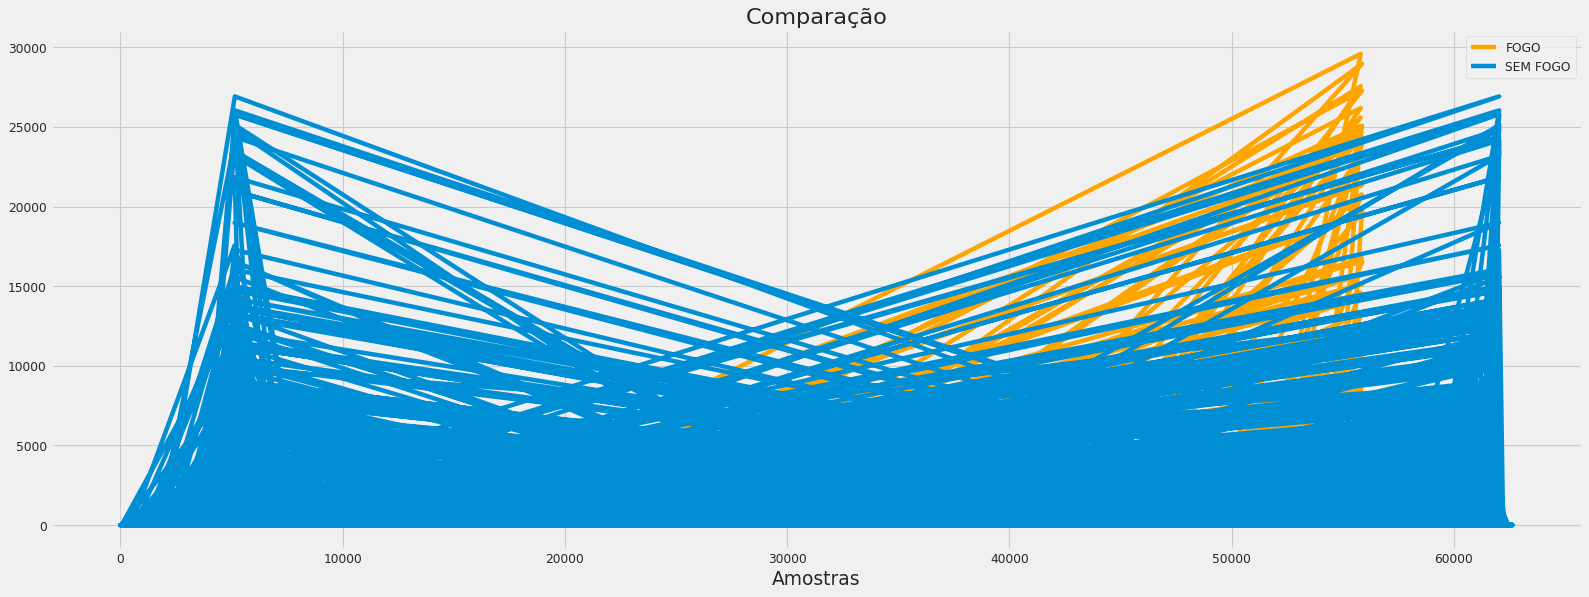

In [197]:
# code
# Visualizing The Open Price of all the stocks
  
# to set the plot size
plt.figure(figsize=(22, 8), dpi=80)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
dataFOGO1['NC25'].plot(label='FOGO', color='orange')
dataFOGO0['NC25'].plot(label='SEM FOGO')
  
# adding title to the plot
plt.title('Comparação')
  
# adding Label to the x-axis
plt.xlabel('Amostras')
  
# adding legend to the curve
plt.legend()

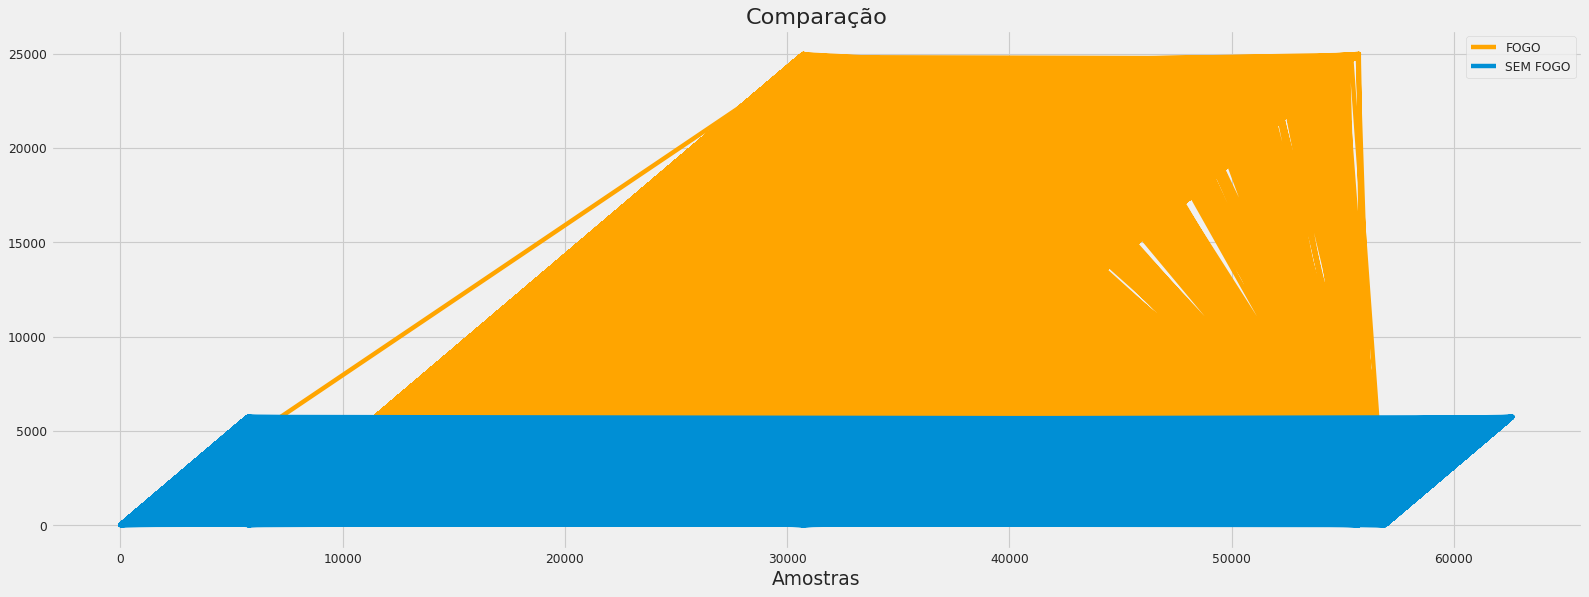

In [198]:
# code
# Visualizing The Open Price of all the stocks
  
# to set the plot size
plt.figure(figsize=(22, 8), dpi=80)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
dataFOGO1['CNT'].plot(label='FOGO', color='orange')
dataFOGO0['CNT'].plot(label='SEM FOGO')
  
# adding title to the plot
plt.title('Comparação')
  
# adding Label to the x-axis
plt.xlabel('Amostras')
  
# adding legend to the curve
plt.legend()

****
## 3° Bootcamp - **Desafio DATA Viking** - Detector de Fumaça
****
- Importação dos dados no ambiente
- Analisar itens dos dados (Campos nulos, duplicados, únicos ...)
- Análises gráficas (EDA) para extrair insights
- Preparação dos dados
- Criação do modelo de Machine Learning
- Avaliação de métricas para o Modelo
E muitos outros.

 Lembrando que os materiais estão disponíveis no Driver e podem ser consultados a todo momento. Inclusive faça o download para deixar na máquina de vocês ou uma cópia no driver. 
 São de extrema ajuda nesse começo de jornada.

**Objetivo**

 Vocês terão que criar um Modelo de Classificação (aprendizado supervisionado) usando a base de dados (anexo no e-mail).
**Pré-requisito**
- É necessário constar no projeto :
- Verificação dos dados (nulos, info, tipos e afins)
- Exploração dos dados usando alguma biblioteca (Matplot, Seaborn ou Plotly) 
- Análises estatísticas (Correlação, Boxplot, Describe e afins)
- Divisão dos dados de treino e teste 
- Criação do modelo  
- Métricas de avaliação (Matriz de confusão e Relatório de classificação )

Data da Entrega 19/10 vocês irão apresentar a nós a solução de vocês.

**Dicionário de dados**
- Temperatura do ar
- Umidade do ar
- TVOC: Compostos Orgânicos Voláteis Totais; medido em partes por bilhão ( Fonte )
- eCO2: concentração equivalente de co2; calculado a partir de valores diferentes como TVCO
- H2 bruto: hidrogênio molecular bruto; não compensado (Viés, temperatura, etc.)
- Etanol bruto: gás etanol bruto ( Fonte )
- Pressão do ar 
- PM 1,0 e PM 2,5: tamanho do material particulado < 1,0 µm (PM1,0). 1,0 µm < 2,5 µm (PM2,5)
- Alarme de incêndio: a verdade do solo é "1" se houver um incêndio
- CNT: contador de amostra
- UTC: timestamp UTC segundos
- NC0.5/NC1.0 e NC2.5: Concentração numérica de material particulado. Isso difere de PM porque NC fornece o número real de partículas no ar. O NC bruto também é classificado pelo tamanho de partícula: < 0,5 µm (NC0,5); 0,5 µm < 1,0 µm (NC1,0); 1,0 µm < 2,5 µm (NC2,5);
**A coluna 'Fire Alarm' é a que consta se era Incendio ou não [ 0 = não, 1 = sim ]**